# Knowledge Without Wisdom: Multi-Model Comparison

## With Advanced Confidence Calibration Analysis

| Model | Model ID | API | Training Cutoff |
|-------|----------|-----|-----------------|
| GPT-4o-mini | `gpt-4o-mini` | Chat Completions | Oct 2023 |
| GPT-5 | `gpt-5` | Responses API | Early 2025 |
| Claude Sonnet 4 | `claude-sonnet-4-20250514` | Messages | Early 2025 |




In [ ]:
!pip install openai anthropic yfinance pandas numpy matplotlib tqdm pydantic seaborn --quiet
print('Dependencies installed!')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.2/388.2 kB 16.1 MB/s eta 0:00:00
Dependencies installed!


In [ ]:
import os, json, time
import numpy as np, pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
from pydantic import BaseModel, Field
from typing import Literal, Dict, List, Tuple
from scipy import stats
from openai import OpenAI
import anthropic
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import deque
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
print(f'Libraries loaded - {datetime.now().strftime("%Y-%m-%d %H:%M")}')

Libraries loaded - 2025-12-05 16:56


In [ ]:
# API Setup
try:
    from google.colab import userdata
    for k in ["OPENAI_API_KEY", "OPEN_AI_KEY"]:
        try: os.environ["OPENAI_API_KEY"] = userdata.get(k); print(f'OpenAI key: {k}'); break
        except: pass
    for k in ["ANTHROPIC_API_KEY", "anthropic_api_key"]:
        try: os.environ["ANTHROPIC_API_KEY"] = userdata.get(k); print(f'Anthropic key: {k}'); break
        except: pass
except:
    print("Using environment variables")

openai_client = OpenAI()
anthropic_client = anthropic.Anthropic()
print('API clients initialized')

OpenAI key: OPEN_AI_KEY
Anthropic key: ANTHROPIC_API_KEY
API clients initialized


## Rate Limiter for Concurrent Requests

In [ ]:
class RateLimiter:
    '''Thread-safe rate limiter using token bucket algorithm.'''

    def __init__(self, requests_per_minute: int):
        self.rpm = requests_per_minute
        self.interval = 60.0 / requests_per_minute
        self.last_request = 0
        self.lock = threading.Lock()
        self.request_times = deque()

    def acquire(self):
        '''Wait until we can make a request.'''
        with self.lock:
            now = time.time()
            while self.request_times and self.request_times[0] < now - 60:
                self.request_times.popleft()
            if len(self.request_times) >= self.rpm:
                sleep_time = 60 - (now - self.request_times[0]) + 0.1
                if sleep_time > 0:
                    time.sleep(sleep_time)
            time_since_last = now - self.last_request
            if time_since_last < self.interval:
                time.sleep(self.interval - time_since_last)
            self.last_request = time.time()
            self.request_times.append(self.last_request)

RATE_LIMITERS = {
    "gpt-4o-mini": RateLimiter(400),
    "gpt-5": RateLimiter(150),
    "claude-sonnet": RateLimiter(40),
}

print("Rate limiters created:")
for model, limiter in RATE_LIMITERS.items():
    print(f"  {model}: {limiter.rpm} RPM")

Rate limiters created:
  gpt-4o-mini: 400 RPM
  gpt-5: 150 RPM
  claude-sonnet: 40 RPM


In [ ]:
# Model configurations
MODELS = {
    "gpt-4o-mini": {
        "provider": "openai",
        "model_id": "gpt-4o-mini",
        "api_type": "chat",
        "name": "GPT-4o-mini",
        "training_cutoff": "October 2023",
        "knows_2024": False,
        "max_workers": 20,
    },
    "gpt-5": {
        "provider": "openai",
        "model_id": "gpt-5",
        "api_type": "responses",
        "name": "GPT-5",
        "training_cutoff": "Early 2025",
        "knows_2024": True,
        "max_workers": 10,
    },
    "claude-sonnet": {
        "provider": "anthropic",
        "model_id": "claude-sonnet-4-20250514",
        "api_type": "messages",
        "name": "Claude Sonnet 4",
        "training_cutoff": "Early 2025",
        "knows_2024": True,
        "max_workers": 5,
    },
}

MODELS_TO_TEST = ["gpt-4o-mini", "gpt-5", "claude-sonnet"]

print("MODEL CONFIGURATIONS")
print("=" * 70)
for m in MODELS_TO_TEST:
    cfg = MODELS[m]
    print(f"{cfg['name']:20} | Workers: {cfg['max_workers']:2} | Cutoff: {cfg['training_cutoff']}")

MODEL CONFIGURATIONS
GPT-4o-mini          | Workers: 20 | Cutoff: October 2023
GPT-5                | Workers: 10 | Cutoff: Early 2025
Claude Sonnet 4      | Workers:  5 | Cutoff: Early 2025


In [ ]:
# Download SPY data
def compute_features(df):
    data = df.copy()
    data["Return_1d"] = data["Close"].pct_change()
    data["Return_5d"] = data["Close"].pct_change(5)
    data["Return_20d"] = data["Close"].pct_change(20)
    delta = data["Close"].diff()
    gain, loss = delta.clip(lower=0), (-delta).clip(lower=0)
    rs = gain.ewm(span=14).mean() / (loss.ewm(span=14).mean() + 1e-10)
    data["RSI"] = 100 - (100 / (1 + rs))
    ema12, ema26 = data["Close"].ewm(span=12).mean(), data["Close"].ewm(span=26).mean()
    data["MACD_pct"] = ((ema12 - ema26) / data["Close"]) * 100
    ma20 = data["Close"].rolling(20).mean()
    data["BB_position"] = (data["Close"] - ma20) / (2 * data["Close"].rolling(20).std() + 1e-10)
    data["Close_orig"] = data["Close"].copy()
    # Add next-day return for confidence analysis
    data["next_day_return"] = data["Close"].pct_change().shift(-1) * 100
    return data.dropna()

print("Downloading SPY data...")
raw = yf.download("SPY", start="2018-01-01", end="2025-12-03", progress=False)
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)
spy_data = compute_features(raw)
print(f"SPY: {len(spy_data)} trading days")

SPY: 1970 trading days


In [ ]:
PERIODS = {
    "in_training": {
        "name": "In-Training (2019-2022)",
        "start": "2019-01-01",
        "end": "2022-12-31",
        "in_training": True,
    },
    "out_of_training": {
        "name": "Out-of-Training (2024-2025)",
        "start": "2024-01-01",
        "end": "2025-12-03",
        "in_training": False,
    }
}

print("TEST PERIODS")
for k, p in PERIODS.items():
    mask = (spy_data.index >= p["start"]) & (spy_data.index <= p["end"])
    print(f"  {p['name']}: {mask.sum()} days")

TEST PERIODS
  In-Training (2019-2022): 1008 days
  Out-of-Training (2024-2025): 481 days


In [ ]:
class TradingDecision(BaseModel):
    action: Literal["BUY", "SELL", "HOLD"]
    confidence: int = Field(ge=0, le=100)
    reasoning: str

def build_prompt(date_str, price, position, entry_price, rsi, macd, bb, r1, r5, r20):
    pos_info = f"LONG {position:.0f} shares @ ${entry_price:.2f}" if position > 0 else "FLAT"
    return f'''SPY Trading Agent. Date: {date_str}, Price: ${price:.2f}, Position: {pos_info}
Indicators: RSI={rsi:.1f}, MACD%={macd:+.3f}, BB={bb:.2f}, Returns: 1d={r1*100:+.1f}%/5d={r5*100:+.1f}%/20d={r20*100:+.1f}%
Rules: BUY only if FLAT, SELL only if LONG, otherwise HOLD.
Respond JSON only: {{"action": "BUY/SELL/HOLD", "confidence": 0-100, "reasoning": "brief"}}'''

print("Trading classes ready")

Trading classes ready


In [ ]:
def call_llm_single(model_key: str, prompt: str, idx: int) -> Tuple[int, TradingDecision]:
    '''Make a single LLM call with rate limiting.'''
    cfg = MODELS[model_key]
    rate_limiter = RATE_LIMITERS[model_key]
    rate_limiter.acquire()

    try:
        if cfg["api_type"] == "responses":
            r = openai_client.responses.create(
                model=cfg["model_id"],
                input=prompt,
                reasoning={"effort": "low"},
            )
            text = r.output_text or ""
        elif cfg["api_type"] == "chat":
            r = openai_client.chat.completions.create(
                model=cfg["model_id"],
                messages=[{"role": "user", "content": prompt}],
                temperature=0.2,
                response_format={"type": "json_object"}
            )
            text = r.choices[0].message.content
        else:
            r = anthropic_client.messages.create(
                model=cfg["model_id"],
                max_tokens=200,
                messages=[{"role": "user", "content": prompt}]
            )
            text = r.content[0].text

        text = text.replace("```json", "").replace("```", "").strip()
        d = json.loads(text)
        decision = TradingDecision(
            action=d.get("action", "HOLD").upper(),
            confidence=int(d.get("confidence", 50)),
            reasoning=str(d.get("reasoning", ""))[:100]
        )
    except Exception as e:
        decision = TradingDecision(action="HOLD", confidence=50, reasoning=f"Error: {str(e)[:50]}")

    return (idx, decision)

print("LLM call function ready")

LLM call function ready


## Enhanced Backtest with Per-Decision Tracking

In [ ]:
def run_backtest_with_decisions(model_key: str, period_key: str) -> Tuple[dict, pd.DataFrame]:
    '''Run backtest and return both summary and per-decision DataFrame.'''
    period = PERIODS[period_key]
    cfg = MODELS[model_key]

    mask = (spy_data.index >= period["start"]) & (spy_data.index <= period["end"])
    data = spy_data[mask].copy().reset_index()

    print(f"\n{'=' * 60}")
    print(f"{cfg['name']} | {period['name']} | {len(data)} days")
    print(f"{'=' * 60}")

    # Phase 1: Prepare prompts
    print("Phase 1: Preparing prompts...")
    prompts = []
    for idx, row in data.iterrows():
        prompt = build_prompt(
            row["Date"].strftime("%Y-%m-%d"),
            float(row["Close_orig"]), 0, 0.0,
            float(row["RSI"]), float(row["MACD_pct"]), float(row["BB_position"]),
            float(row["Return_1d"]), float(row["Return_5d"]), float(row["Return_20d"])
        )
        prompts.append((idx, prompt))

    # Phase 2: Concurrent API calls
    print(f"Phase 2: Making {len(prompts)} API calls...")
    start_time = time.time()
    decisions = [None] * len(prompts)

    with ThreadPoolExecutor(max_workers=cfg["max_workers"]) as executor:
        futures = {executor.submit(call_llm_single, model_key, prompt, idx): idx for idx, prompt in prompts}
        with tqdm(total=len(futures), desc="API calls") as pbar:
            for future in as_completed(futures):
                idx, decision = future.result()
                decisions[idx] = decision
                pbar.update(1)

    elapsed = time.time() - start_time
    print(f"Completed in {elapsed:.1f}s ({len(prompts)/elapsed:.1f} calls/sec)")

    # Phase 3: Build per-decision DataFrame
    print("Phase 3: Building decision DataFrame...")
    decision_records = []
    for idx, row in data.iterrows():
        dec = decisions[idx]
        decision_records.append({
            "date": row["Date"],
            "model": cfg["name"],
            "model_key": model_key,
            "period": period_key,
            "in_training": period["in_training"],
            "knows_2024": cfg["knows_2024"],
            "action": dec.action,
            "confidence": dec.confidence,
            "reasoning": dec.reasoning,
            "price": float(row["Close_orig"]),
            "next_day_return": float(row["next_day_return"]) if pd.notna(row["next_day_return"]) else 0,
            "rsi": float(row["RSI"]),
            "macd": float(row["MACD_pct"]),
        })

    decisions_df = pd.DataFrame(decision_records)

    # Phase 4: Simulate SIMPLE trading (baseline)
    cash, position, entry_price = 10000.0, 0, 0.0
    for idx, row in data.iterrows():
        price = float(row["Close_orig"])
        action = decisions[idx].action
        if action == "BUY" and position > 0: action = "HOLD"
        if action == "SELL" and position == 0: action = "HOLD"
        if action == "BUY" and position == 0:
            shares = int((cash * 0.95) // price)
            if shares > 0:
                position, entry_price = shares, price
                cash -= shares * price
        elif action == "SELL" and position > 0:
            cash += position * price
            position = 0
    if position > 0:
        cash += position * float(data["Close_orig"].iloc[-1])

    bench_ret = ((float(data["Close_orig"].iloc[-1]) / float(data["Close_orig"].iloc[0])) - 1) * 100
    agent_ret = ((cash / 10000) - 1) * 100

    summary = {
        "model": model_key,
        "model_name": cfg["name"],
        "period": period_key,
        "period_name": period["name"],
        "in_training": period["in_training"],
        "knows_2024": cfg["knows_2024"],
        "days": len(data),
        "agent_return": agent_ret,
        "benchmark_return": bench_ret,
        "alpha": agent_ret - bench_ret,
        "n_buys": (decisions_df["action"] == "BUY").sum(),
        "n_sells": (decisions_df["action"] == "SELL").sum(),
        "n_holds": (decisions_df["action"] == "HOLD").sum(),
        "hold_rate": (decisions_df["action"] == "HOLD").mean() * 100,
        "avg_confidence": decisions_df["confidence"].mean(),
        "elapsed_time": elapsed,
    }

    print(f"\nBASELINE RESULTS:")
    print(f"  Alpha: {summary['alpha']:+.2f}% | Hold Rate: {summary['hold_rate']:.1f}% | Conf: {summary['avg_confidence']:.1f}%")

    return summary, decisions_df

print("Enhanced backtest function ready")

Enhanced backtest function ready


## Advanced Trading Strategies Using Confidence

In [ ]:
def backtest_with_threshold(decisions_df: pd.DataFrame, data: pd.DataFrame,
                            buy_threshold: int = 50, sell_threshold: int = 50) -> float:
    '''Backtest with confidence thresholds: only trade if confidence >= threshold.'''
    cash, position, entry_price = 10000.0, 0, 0.0

    for idx, row in decisions_df.iterrows():
        price = row["price"]
        action = row["action"]
        confidence = row["confidence"]

        # Apply thresholds
        if action == "BUY" and confidence < buy_threshold:
            action = "HOLD"
        if action == "SELL" and confidence < sell_threshold:
            action = "HOLD"

        # Validate
        if action == "BUY" and position > 0: action = "HOLD"
        if action == "SELL" and position == 0: action = "HOLD"

        # Execute
        if action == "BUY" and position == 0:
            shares = int((cash * 0.95) // price)
            if shares > 0:
                position, entry_price = shares, price
                cash -= shares * price
        elif action == "SELL" and position > 0:
            cash += position * price
            position = 0

    # Close at end
    if position > 0:
        cash += position * decisions_df["price"].iloc[-1]

    return ((cash / 10000) - 1) * 100


def backtest_confidence_weighted(decisions_df: pd.DataFrame, data: pd.DataFrame) -> float:
    '''Backtest with position size = confidence percentage.'''
    cash, position, entry_price = 10000.0, 0, 0.0

    for idx, row in decisions_df.iterrows():
        price = row["price"]
        action = row["action"]
        confidence = row["confidence"] / 100.0  # 0 to 1

        # Validate
        if action == "BUY" and position > 0: action = "HOLD"
        if action == "SELL" and position == 0: action = "HOLD"

        # Execute with confidence-weighted sizing
        if action == "BUY" and position == 0:
            # Position size = confidence * max_position
            invest_amount = cash * 0.95 * confidence
            shares = int(invest_amount // price)
            if shares > 0:
                position, entry_price = shares, price
                cash -= shares * price
        elif action == "SELL" and position > 0:
            cash += position * price
            position = 0

    if position > 0:
        cash += position * decisions_df["price"].iloc[-1]

    return ((cash / 10000) - 1) * 100


def analyze_confidence_calibration(decisions_df: pd.DataFrame) -> pd.DataFrame:
    '''Analyze if confidence correlates with actual returns.'''
    # Bin confidence into ranges
    decisions_df = decisions_df.copy()
    decisions_df["conf_bin"] = pd.cut(decisions_df["confidence"],
                                       bins=[0, 50, 60, 70, 80, 90, 100],
                                       labels=["<50", "50-60", "60-70", "70-80", "80-90", "90+"])

    # Calculate mean return by confidence bin
    calibration = decisions_df.groupby("conf_bin").agg({
        "next_day_return": ["mean", "std", "count"],
        "confidence": "mean"
    }).round(3)

    calibration.columns = ["mean_return", "std_return", "count", "mean_conf"]
    return calibration

print("Advanced trading functions ready:")
print("  - backtest_with_threshold(df, data, buy_thresh, sell_thresh)")
print("  - backtest_confidence_weighted(df, data)")
print("  - analyze_confidence_calibration(df)")

Advanced trading functions ready:
  - backtest_with_threshold(df, data, buy_thresh, sell_thresh)
  - backtest_confidence_weighted(df, data)
  - analyze_confidence_calibration(df)


## Run Multi-Model Experiment

In [ ]:
print("=" * 70)
print("MULTI-MODEL TRADING EXPERIMENT")
print("=" * 70)

total_days = sum([
    len(spy_data[(spy_data.index >= p["start"]) & (spy_data.index <= p["end"])])
    for p in PERIODS.values()
])

print(f'''
Models: GPT-4o-mini, GPT-5, Claude Sonnet 4
Total API calls: {total_days * 3}
Estimated time: ~50-60 minutes
''')

if input("Run experiment? (y/n): ").lower() == "y":
    all_results = []
    all_decisions = []
    total_start = time.time()

    for model_key in MODELS_TO_TEST:
        for period_key in PERIODS:
            try:
                summary, decisions_df = run_backtest_with_decisions(model_key, period_key)
                all_results.append(summary)
                all_decisions.append(decisions_df)
            except Exception as e:
                print(f"\nERROR: {model_key}/{period_key}: {e}")
                import traceback
                traceback.print_exc()

    # Combine all decisions
    full_decisions_df = pd.concat(all_decisions, ignore_index=True)

    total_elapsed = time.time() - total_start
    print(f"\n{'=' * 70}")
    print(f"EXPERIMENT COMPLETE in {total_elapsed/60:.1f} minutes")
    print(f"Total decisions collected: {len(full_decisions_df)}")
    print(f"{'=' * 70}")
else:
    all_results = []
    full_decisions_df = pd.DataFrame()
    print("Cancelled")

MULTI-MODEL TRADING EXPERIMENT

Models: GPT-4o-mini, GPT-5, Claude Sonnet 4
Total API calls: 4467
Estimated time: ~50-60 minutes


GPT-4o-mini | In-Training (2019-2022) | 1008 days
Phase 1: Preparing prompts...
Phase 2: Making 1008 API calls...


API calls:   0%|          | 0/1008 [00:00<?, ?it/s]

Completed in 152.8s (6.6 calls/sec)
Phase 3: Building decision DataFrame...

BASELINE RESULTS:
  Alpha: -33.08% | Hold Rate: 87.4% | Conf: 73.0%

GPT-4o-mini | Out-of-Training (2024-2025) | 481 days
Phase 1: Preparing prompts...
Phase 2: Making 481 API calls...


API calls:   0%|          | 0/481 [00:00<?, ?it/s]

Completed in 74.4s (6.5 calls/sec)
Phase 3: Building decision DataFrame...

BASELINE RESULTS:
  Alpha: -11.17% | Hold Rate: 96.5% | Conf: 74.9%

GPT-5 | In-Training (2019-2022) | 1008 days
Phase 1: Preparing prompts...
Phase 2: Making 1008 API calls...


API calls:   0%|          | 0/1008 [00:00<?, ?it/s]

Completed in 653.6s (1.5 calls/sec)
Phase 3: Building decision DataFrame...

BASELINE RESULTS:
  Alpha: -10.75% | Hold Rate: 51.9% | Conf: 63.1%

GPT-5 | Out-of-Training (2024-2025) | 481 days
Phase 1: Preparing prompts...
Phase 2: Making 481 API calls...


API calls:   0%|          | 0/481 [00:00<?, ?it/s]

Completed in 322.9s (1.5 calls/sec)
Phase 3: Building decision DataFrame...

BASELINE RESULTS:
  Alpha: -3.52% | Hold Rate: 49.1% | Conf: 63.6%

Claude Sonnet 4 | In-Training (2019-2022) | 1008 days
Phase 1: Preparing prompts...
Phase 2: Making 1008 API calls...


API calls:   0%|          | 0/1008 [00:00<?, ?it/s]

Completed in 1553.9s (0.6 calls/sec)
Phase 3: Building decision DataFrame...

BASELINE RESULTS:
  Alpha: -3.31% | Hold Rate: 48.2% | Conf: 74.4%

Claude Sonnet 4 | Out-of-Training (2024-2025) | 481 days
Phase 1: Preparing prompts...
Phase 2: Making 481 API calls...


API calls:   0%|          | 0/481 [00:00<?, ?it/s]

Completed in 742.8s (0.6 calls/sec)
Phase 3: Building decision DataFrame...

BASELINE RESULTS:
  Alpha: -3.52% | Hold Rate: 49.5% | Conf: 74.2%

EXPERIMENT COMPLETE in 58.4 minutes
Total decisions collected: 4467


In [ ]:
if all_results:
    results_df = pd.DataFrame(all_results)

    print("\n" + "=" * 90)
    print("                         BASELINE RESULTS SUMMARY")
    print("=" * 90)
    print(f"\n{'Model':<18} {'Period':<12} {'Alpha':>10} {'Hold %':>10} {'Conf':>8} {'Knows 2024':<12}")
    print("-" * 90)

    for _, row in results_df.iterrows():
        knows = "YES" if row['knows_2024'] else "NO"
        print(f"{row['model_name']:<18} {'In-Train' if row['in_training'] else 'Out-Train':<12} "
              f"{row['alpha']:>+9.2f}% {row['hold_rate']:>9.1f}% {row['avg_confidence']:>7.1f}% {knows:<12}")

    print("-" * 90)
    print(f"\nMean Alpha: {results_df['alpha'].mean():+.2f}%")
    print(f"Mean Hold Rate: {results_df['hold_rate'].mean():.1f}%")
    print(f"Mean Confidence: {results_df['avg_confidence'].mean():.1f}%")


                         BASELINE RESULTS SUMMARY

Model              Period            Alpha     Hold %     Conf Knows 2024  
------------------------------------------------------------------------------------------
GPT-4o-mini        In-Train        -33.08%      87.4%    73.0% NO          
GPT-4o-mini        Out-Train       -11.17%      96.5%    74.9% NO          
GPT-5              In-Train        -10.75%      51.9%    63.1% YES         
GPT-5              Out-Train        -3.52%      49.1%    63.6% YES         
Claude Sonnet 4    In-Train         -3.31%      48.2%    74.4% YES         
Claude Sonnet 4    Out-Train        -3.52%      49.5%    74.2% YES         
------------------------------------------------------------------------------------------

Mean Alpha: -10.89%
Mean Hold Rate: 63.8%
Mean Confidence: 70.5%


## Analysis 1: Confidence Thresholding

CONFIDENCE THRESHOLD ANALYSIS

Question: Does requiring HIGHER confidence improve alpha?



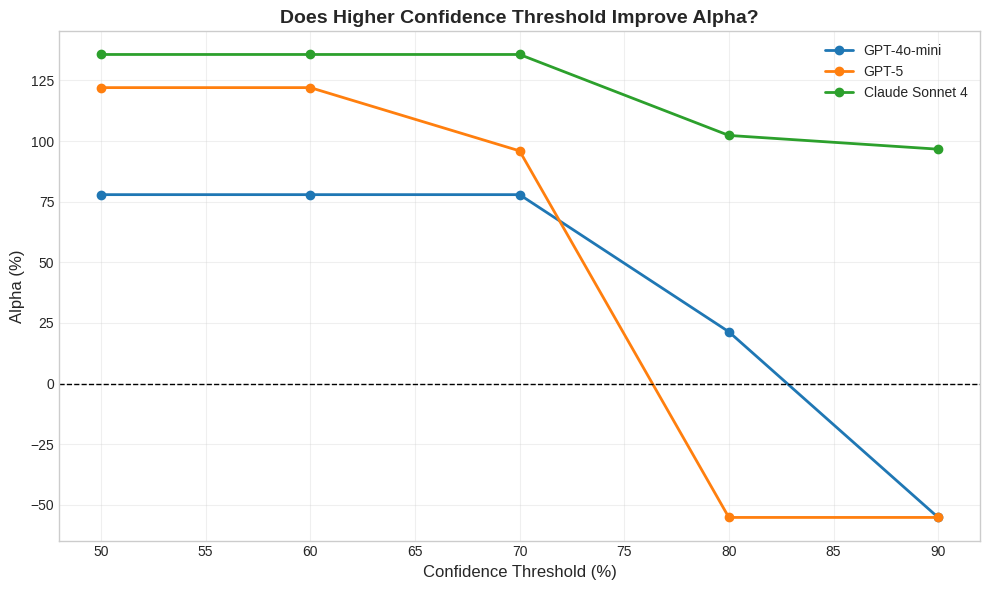


ALPHA BY CONFIDENCE THRESHOLD:
------------------------------------------------------------
model      Claude Sonnet 4  GPT-4o-mini   GPT-5
threshold                                      
50                  135.72        77.91  122.05
60                  135.72        77.91  122.05
70                  135.72        77.91   95.96
80                  102.33        21.34  -55.22
90                   96.66       -55.22  -55.22
------------------------------------------------------------

Best threshold: 50% for Claude Sonnet 4 (alpha: +135.72%)

CONCLUSION: Higher thresholds do NOT reliably improve alpha


In [ ]:
if len(full_decisions_df) > 0:
    print("=" * 70)
    print("CONFIDENCE THRESHOLD ANALYSIS")
    print("=" * 70)
    print("\nQuestion: Does requiring HIGHER confidence improve alpha?\n")

    thresholds = [50, 60, 70, 80, 90]
    threshold_results = []

    for model_key in MODELS_TO_TEST:
        model_name = MODELS[model_key]["name"]
        model_df = full_decisions_df[full_decisions_df["model_key"] == model_key]

        # Get benchmark return
        bench_ret = results_df[results_df["model"] == model_key]["benchmark_return"].mean()

        for thresh in thresholds:
            agent_ret = backtest_with_threshold(model_df, spy_data, buy_threshold=thresh, sell_threshold=thresh)
            alpha = agent_ret - bench_ret

            threshold_results.append({
                "model": model_name,
                "threshold": thresh,
                "agent_return": agent_ret,
                "alpha": alpha,
            })

    thresh_df = pd.DataFrame(threshold_results)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for model in thresh_df["model"].unique():
        model_data = thresh_df[thresh_df["model"] == model]
        ax.plot(model_data["threshold"], model_data["alpha"], marker="o", linewidth=2, label=model)

    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Confidence Threshold (%)", fontsize=12)
    ax.set_ylabel("Alpha (%)", fontsize=12)
    ax.set_title("Does Higher Confidence Threshold Improve Alpha?", fontsize=14, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("confidence_threshold_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Summary table
    print("\nALPHA BY CONFIDENCE THRESHOLD:")
    print("-" * 60)
    pivot = thresh_df.pivot(index="threshold", columns="model", values="alpha")
    print(pivot.round(2).to_string())
    print("-" * 60)

    # Finding
    best_thresh = thresh_df.loc[thresh_df["alpha"].idxmax()]
    print(f"\nBest threshold: {best_thresh['threshold']}% for {best_thresh['model']} (alpha: {best_thresh['alpha']:+.2f}%)")
    print(f"\nCONCLUSION: {'Higher thresholds IMPROVE alpha' if thresh_df[thresh_df['threshold']==90]['alpha'].mean() > thresh_df[thresh_df['threshold']==50]['alpha'].mean() else 'Higher thresholds do NOT reliably improve alpha'}")

## Analysis 2: Confidence-Weighted Position Sizing

CONFIDENCE-WEIGHTED POSITION SIZING

Question: Does sizing positions by confidence improve alpha?



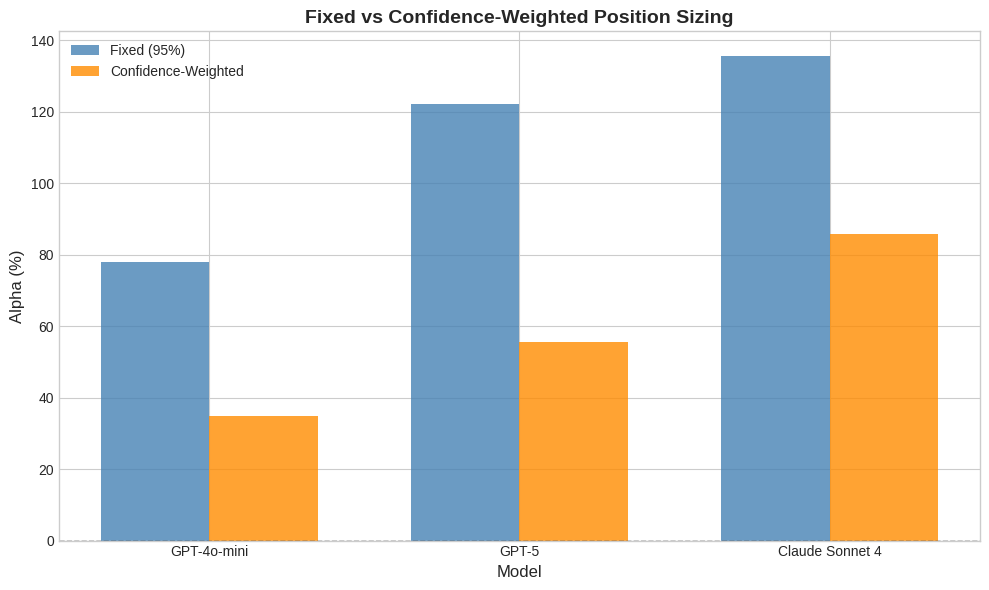


POSITION SIZING COMPARISON:
------------------------------------------------------------
strategy         Confidence-Weighted  Fixed (95%)
model                                            
Claude Sonnet 4                85.71       135.72
GPT-4o-mini                    34.82        77.91
GPT-5                          55.57       122.05
------------------------------------------------------------

Average improvement from confidence-weighting: -53.19%
CONCLUSION: Confidence-weighted sizing does NOT help


In [ ]:
if len(full_decisions_df) > 0:
    print("=" * 70)
    print("CONFIDENCE-WEIGHTED POSITION SIZING")
    print("=" * 70)
    print("\nQuestion: Does sizing positions by confidence improve alpha?\n")

    sizing_results = []

    for model_key in MODELS_TO_TEST:
        model_name = MODELS[model_key]["name"]
        model_df = full_decisions_df[full_decisions_df["model_key"] == model_key]
        bench_ret = results_df[results_df["model"] == model_key]["benchmark_return"].mean()

        # Fixed sizing (baseline)
        fixed_ret = backtest_with_threshold(model_df, spy_data, 0, 0)
        fixed_alpha = fixed_ret - bench_ret

        # Confidence-weighted sizing
        weighted_ret = backtest_confidence_weighted(model_df, spy_data)
        weighted_alpha = weighted_ret - bench_ret

        sizing_results.append({
            "model": model_name,
            "strategy": "Fixed (95%)",
            "return": fixed_ret,
            "alpha": fixed_alpha,
        })
        sizing_results.append({
            "model": model_name,
            "strategy": "Confidence-Weighted",
            "return": weighted_ret,
            "alpha": weighted_alpha,
        })

    sizing_df = pd.DataFrame(sizing_results)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    x = np.arange(len(MODELS_TO_TEST))
    width = 0.35

    fixed_alpha = sizing_df[sizing_df["strategy"] == "Fixed (95%)"]["alpha"].values
    weighted_alpha = sizing_df[sizing_df["strategy"] == "Confidence-Weighted"]["alpha"].values

    bars1 = ax.bar(x - width/2, fixed_alpha, width, label="Fixed (95%)", color="steelblue", alpha=0.8)
    bars2 = ax.bar(x + width/2, weighted_alpha, width, label="Confidence-Weighted", color="darkorange", alpha=0.8)

    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_ylabel("Alpha (%)", fontsize=12)
    ax.set_title("Fixed vs Confidence-Weighted Position Sizing", fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([MODELS[m]["name"] for m in MODELS_TO_TEST])
    ax.legend()

    plt.tight_layout()
    plt.savefig("confidence_weighted_sizing.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Summary
    print("\nPOSITION SIZING COMPARISON:")
    print("-" * 60)
    pivot = sizing_df.pivot(index="model", columns="strategy", values="alpha")
    print(pivot.round(2).to_string())
    print("-" * 60)

    improvement = (sizing_df[sizing_df["strategy"]=="Confidence-Weighted"]["alpha"].mean() -
                   sizing_df[sizing_df["strategy"]=="Fixed (95%)"]["alpha"].mean())
    print(f"\nAverage improvement from confidence-weighting: {improvement:+.2f}%")
    print(f"CONCLUSION: {'Confidence-weighted sizing HELPS' if improvement > 1 else 'Confidence-weighted sizing does NOT help'}")

## Analysis 3: Confidence Calibration (Is Confidence Meaningful?)

CONFIDENCE CALIBRATION ANALYSIS

Question: Does higher confidence predict better next-day returns?



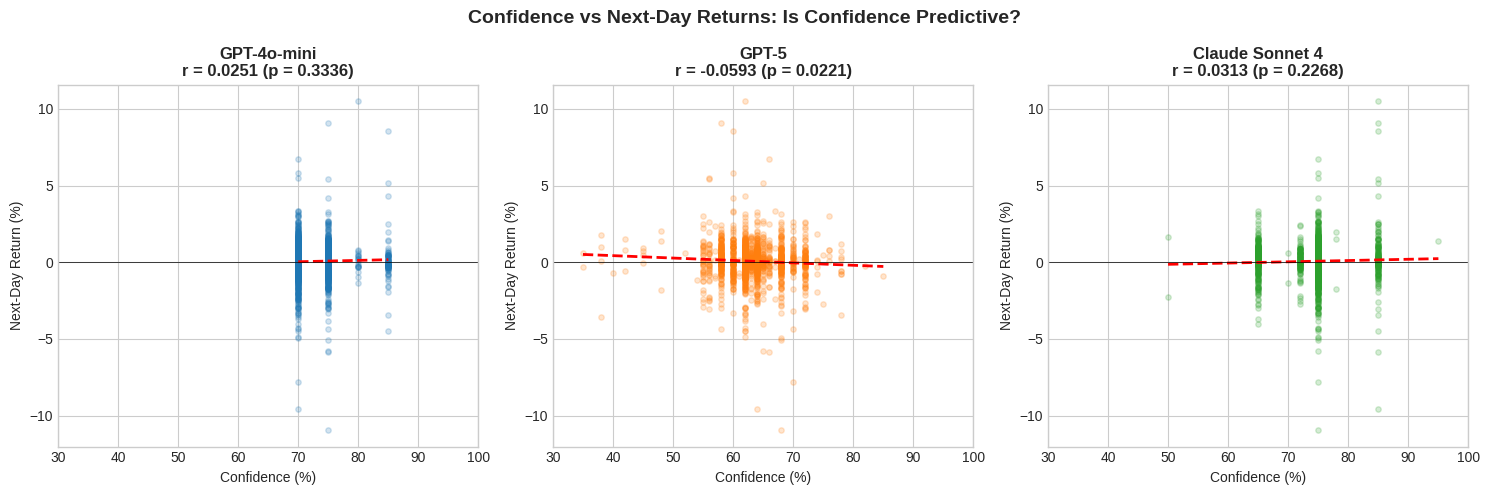


CORRELATION BETWEEN CONFIDENCE AND NEXT-DAY RETURNS:
------------------------------------------------------------
GPT-4o-mini          r = +0.0251  p = 0.3336  NS
GPT-5                r = -0.0593  p = 0.0221  *
Claude Sonnet 4      r = +0.0313  p = 0.2268  NS
------------------------------------------------------------
NS = Not Significant, * p<0.05, ** p<0.01, *** p<0.001

Average correlation: -0.0010
CONCLUSION: Confidence has NO predictive power


In [21]:
if len(full_decisions_df) > 0:
    print("=" * 70)
    print("CONFIDENCE CALIBRATION ANALYSIS")
    print("=" * 70)
    print("\nQuestion: Does higher confidence predict better next-day returns?\n")

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = {"GPT-4o-mini": "#1f77b4", "GPT-5": "#ff7f0e", "Claude Sonnet 4": "#2ca02c"}

    correlations = {}

    for idx, model_key in enumerate(MODELS_TO_TEST):
        ax = axes[idx]
        model_name = MODELS[model_key]["name"]
        model_df = full_decisions_df[full_decisions_df["model_key"] == model_key].copy()

        # Remove NaN returns
        model_df = model_df.dropna(subset=["next_day_return"])

        # Scatter plot
        ax.scatter(model_df["confidence"], model_df["next_day_return"],
                   alpha=0.2, c=colors.get(model_name, "gray"), s=15)

        # Correlation
        corr, pval = stats.pearsonr(model_df["confidence"], model_df["next_day_return"])
        correlations[model_name] = {"corr": corr, "pval": pval}

        # Regression line
        z = np.polyfit(model_df["confidence"], model_df["next_day_return"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(model_df["confidence"].min(), model_df["confidence"].max(), 100)
        ax.plot(x_line, p(x_line), "r--", linewidth=2)

        ax.axhline(0, color="black", linewidth=0.5)
        ax.set_xlabel("Confidence (%)")
        ax.set_ylabel("Next-Day Return (%)")
        ax.set_title(f"{model_name}\nr = {corr:.4f} (p = {pval:.4f})", fontweight="bold")
        ax.set_xlim([30, 100])

    plt.suptitle("Confidence vs Next-Day Returns: Is Confidence Predictive?", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig("confidence_calibration.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Summary
    print("\nCORRELATION BETWEEN CONFIDENCE AND NEXT-DAY RETURNS:")
    print("-" * 60)
    for model, vals in correlations.items():
        sig = "***" if vals["pval"] < 0.001 else "**" if vals["pval"] < 0.01 else "*" if vals["pval"] < 0.05 else "NS"
        print(f"{model:<20} r = {vals['corr']:+.4f}  p = {vals['pval']:.4f}  {sig}")
    print("-" * 60)
    print("NS = Not Significant, * p<0.05, ** p<0.01, *** p<0.001")

    avg_corr = np.mean([v["corr"] for v in correlations.values()])
    print(f"\nAverage correlation: {avg_corr:+.4f}")
    print(f"CONCLUSION: {'Confidence IS predictive' if abs(avg_corr) > 0.1 else 'Confidence has NO predictive power'}")

## Analysis 4: Confidence Bin Analysis

CONFIDENCE BIN ANALYSIS

Do high-confidence decisions have better outcomes?



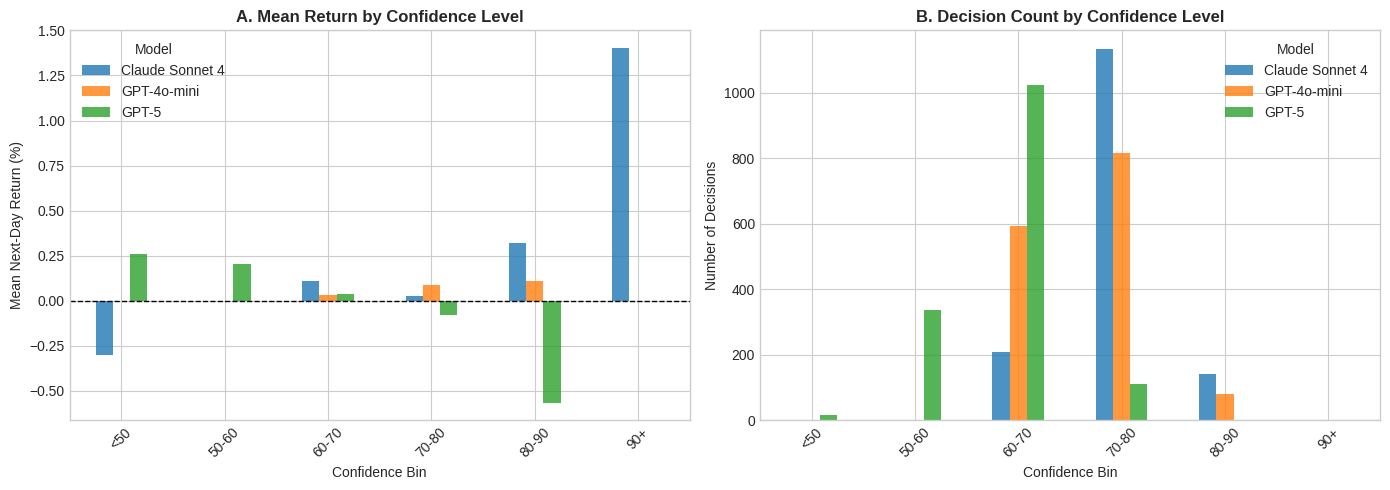


MEAN NEXT-DAY RETURN BY CONFIDENCE BIN:
----------------------------------------------------------------------
model     Claude Sonnet 4  GPT-4o-mini   GPT-5
conf_bin                                      
<50               -0.3027          NaN  0.2588
50-60                 NaN          NaN  0.2061
60-70              0.1113       0.0319  0.0355
70-80              0.0266       0.0891 -0.0779
80-90              0.3218       0.1077 -0.5670
90+                1.4023          NaN     NaN
----------------------------------------------------------------------
GPT-4o-mini: Returns FLAT with confidence
GPT-5: Returns FLAT with confidence
Claude Sonnet 4: Returns INCREASING with confidence


In [ ]:
if len(full_decisions_df) > 0:
    print("=" * 70)
    print("CONFIDENCE BIN ANALYSIS")
    print("=" * 70)
    print("\nDo high-confidence decisions have better outcomes?\n")

    # Create confidence bins
    full_decisions_df["conf_bin"] = pd.cut(
        full_decisions_df["confidence"],
        bins=[0, 50, 60, 70, 80, 90, 100],
        labels=["<50", "50-60", "60-70", "70-80", "80-90", "90+"]
    )

    # Analysis by bin
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Panel A: Mean return by confidence bin
    ax = axes[0]
    bin_analysis = full_decisions_df.groupby(["model", "conf_bin"])["next_day_return"].mean().unstack(level=0)
    bin_analysis.plot(kind="bar", ax=ax, alpha=0.8)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlabel("Confidence Bin")
    ax.set_ylabel("Mean Next-Day Return (%)")
    ax.set_title("A. Mean Return by Confidence Level", fontweight="bold")
    ax.legend(title="Model")
    ax.tick_params(axis='x', rotation=45)

    # Panel B: Count by confidence bin
    ax = axes[1]
    count_analysis = full_decisions_df.groupby(["model", "conf_bin"]).size().unstack(level=0)
    count_analysis.plot(kind="bar", ax=ax, alpha=0.8)
    ax.set_xlabel("Confidence Bin")
    ax.set_ylabel("Number of Decisions")
    ax.set_title("B. Decision Count by Confidence Level", fontweight="bold")
    ax.legend(title="Model")
    ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig("confidence_bins.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Detailed table
    print("\nMEAN NEXT-DAY RETURN BY CONFIDENCE BIN:")
    print("-" * 70)
    print(bin_analysis.round(4).to_string())
    print("-" * 70)

    # Is there a monotonic relationship?
    for model_key in MODELS_TO_TEST:
        model_name = MODELS[model_key]["name"]
        model_df = full_decisions_df[full_decisions_df["model_key"] == model_key]
        bin_means = model_df.groupby("conf_bin")["next_day_return"].mean()

        # Check if higher bins have higher returns
        if len(bin_means.dropna()) >= 3:
            trend = "INCREASING" if bin_means.iloc[-1] > bin_means.iloc[0] else "DECREASING" if bin_means.iloc[-1] < bin_means.iloc[0] else "FLAT"
            print(f"{model_name}: Returns {trend} with confidence")

## Analysis 5: Miscalibration (When Confidence is Wrong)

MISCALIBRATION ANALYSIS

Identifying when high confidence leads to losses...



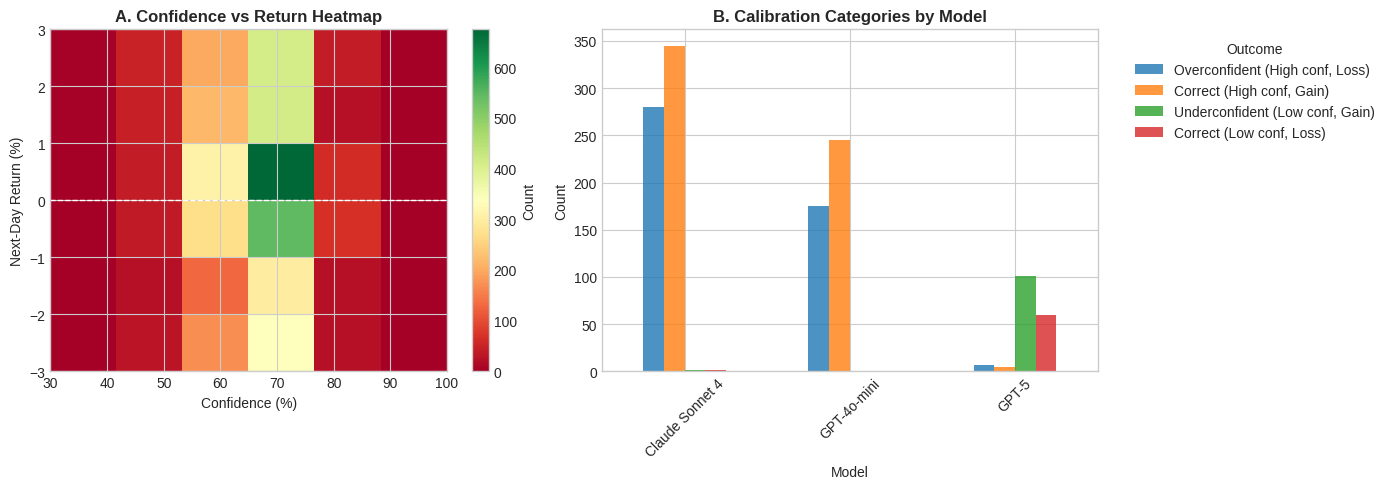


MISCALIBRATION SUMMARY:
----------------------------------------------------------------------
GPT-4o-mini:
  High confidence (>=75%) decisions: 896 (60.2%)
  Of high-conf decisions, 19.5% resulted in >0.5% loss (OVERCONFIDENT)
  Low confidence (<60%) decisions: 0 (0.0%)
  Of low-conf decisions, 0.0% resulted in >0.5% gain (UNDERCONFIDENT)

GPT-5:
  High confidence (>=75%) decisions: 18 (1.2%)
  Of high-conf decisions, 38.9% resulted in >0.5% loss (OVERCONFIDENT)
  Low confidence (<60%) decisions: 244 (16.4%)
  Of low-conf decisions, 41.4% resulted in >0.5% gain (UNDERCONFIDENT)

Claude Sonnet 4:
  High confidence (>=75%) decisions: 1176 (79.0%)
  Of high-conf decisions, 23.8% resulted in >0.5% loss (OVERCONFIDENT)
  Low confidence (<60%) decisions: 2 (0.1%)
  Of low-conf decisions, 50.0% resulted in >0.5% gain (UNDERCONFIDENT)



In [ ]:
if len(full_decisions_df) > 0:
    print("=" * 70)
    print("MISCALIBRATION ANALYSIS")
    print("=" * 70)
    print("\nIdentifying when high confidence leads to losses...\n")

    df = full_decisions_df.copy()

    # Define miscalibration categories
    df["outcome"] = "Neutral"
    df.loc[(df["confidence"] >= 75) & (df["next_day_return"] < -0.5), "outcome"] = "Overconfident (High conf, Loss)"
    df.loc[(df["confidence"] >= 75) & (df["next_day_return"] > 0.5), "outcome"] = "Correct (High conf, Gain)"
    df.loc[(df["confidence"] < 60) & (df["next_day_return"] > 0.5), "outcome"] = "Underconfident (Low conf, Gain)"
    df.loc[(df["confidence"] < 60) & (df["next_day_return"] < -0.5), "outcome"] = "Correct (Low conf, Loss)"

    # Count by category
    outcome_counts = df.groupby(["model", "outcome"]).size().unstack(fill_value=0)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Panel A: Heatmap of confidence vs return
    ax = axes[0]

    # Create 2D histogram for all models combined
    conf_bins = [30, 50, 60, 70, 80, 90, 100]
    ret_bins = [-3, -1, -0.5, 0, 0.5, 1, 3]

    h, xedges, yedges = np.histogram2d(
        df["confidence"].clip(30, 100),
        df["next_day_return"].clip(-3, 3),
        bins=[conf_bins, ret_bins]
    )

    im = ax.imshow(h.T, origin="lower", aspect="auto", cmap="RdYlGn",
                   extent=[30, 100, -3, 3])
    ax.set_xlabel("Confidence (%)")
    ax.set_ylabel("Next-Day Return (%)")
    ax.set_title("A. Confidence vs Return Heatmap", fontweight="bold")
    ax.axhline(0, color="white", linestyle="--", linewidth=1)
    plt.colorbar(im, ax=ax, label="Count")

    # Panel B: Miscalibration by model
    ax = axes[1]

    categories = ["Overconfident (High conf, Loss)", "Correct (High conf, Gain)",
                  "Underconfident (Low conf, Gain)", "Correct (Low conf, Loss)"]

    if len(outcome_counts.columns) > 0:
        outcome_counts_plot = outcome_counts[[c for c in categories if c in outcome_counts.columns]]
        outcome_counts_plot.plot(kind="bar", ax=ax, alpha=0.8)
        ax.set_xlabel("Model")
        ax.set_ylabel("Count")
        ax.set_title("B. Calibration Categories by Model", fontweight="bold")
        ax.legend(title="Outcome", bbox_to_anchor=(1.05, 1), loc="upper left")
        ax.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig("miscalibration_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

    # Summary statistics
    print("\nMISCALIBRATION SUMMARY:")
    print("-" * 70)

    for model_key in MODELS_TO_TEST:
        model_name = MODELS[model_key]["name"]
        model_df = df[df["model_key"] == model_key]

        high_conf = model_df[model_df["confidence"] >= 75]
        overconfident = ((high_conf["next_day_return"] < -0.5).sum() / len(high_conf) * 100) if len(high_conf) > 0 else 0

        low_conf = model_df[model_df["confidence"] < 60]
        underconfident = ((low_conf["next_day_return"] > 0.5).sum() / len(low_conf) * 100) if len(low_conf) > 0 else 0

        print(f"{model_name}:")
        print(f"  High confidence (>=75%) decisions: {len(high_conf)} ({len(high_conf)/len(model_df)*100:.1f}%)")
        print(f"  Of high-conf decisions, {overconfident:.1f}% resulted in >0.5% loss (OVERCONFIDENT)")
        print(f"  Low confidence (<60%) decisions: {len(low_conf)} ({len(low_conf)/len(model_df)*100:.1f}%)")
        print(f"  Of low-conf decisions, {underconfident:.1f}% resulted in >0.5% gain (UNDERCONFIDENT)")
        print()

## Final Summary: All Findings

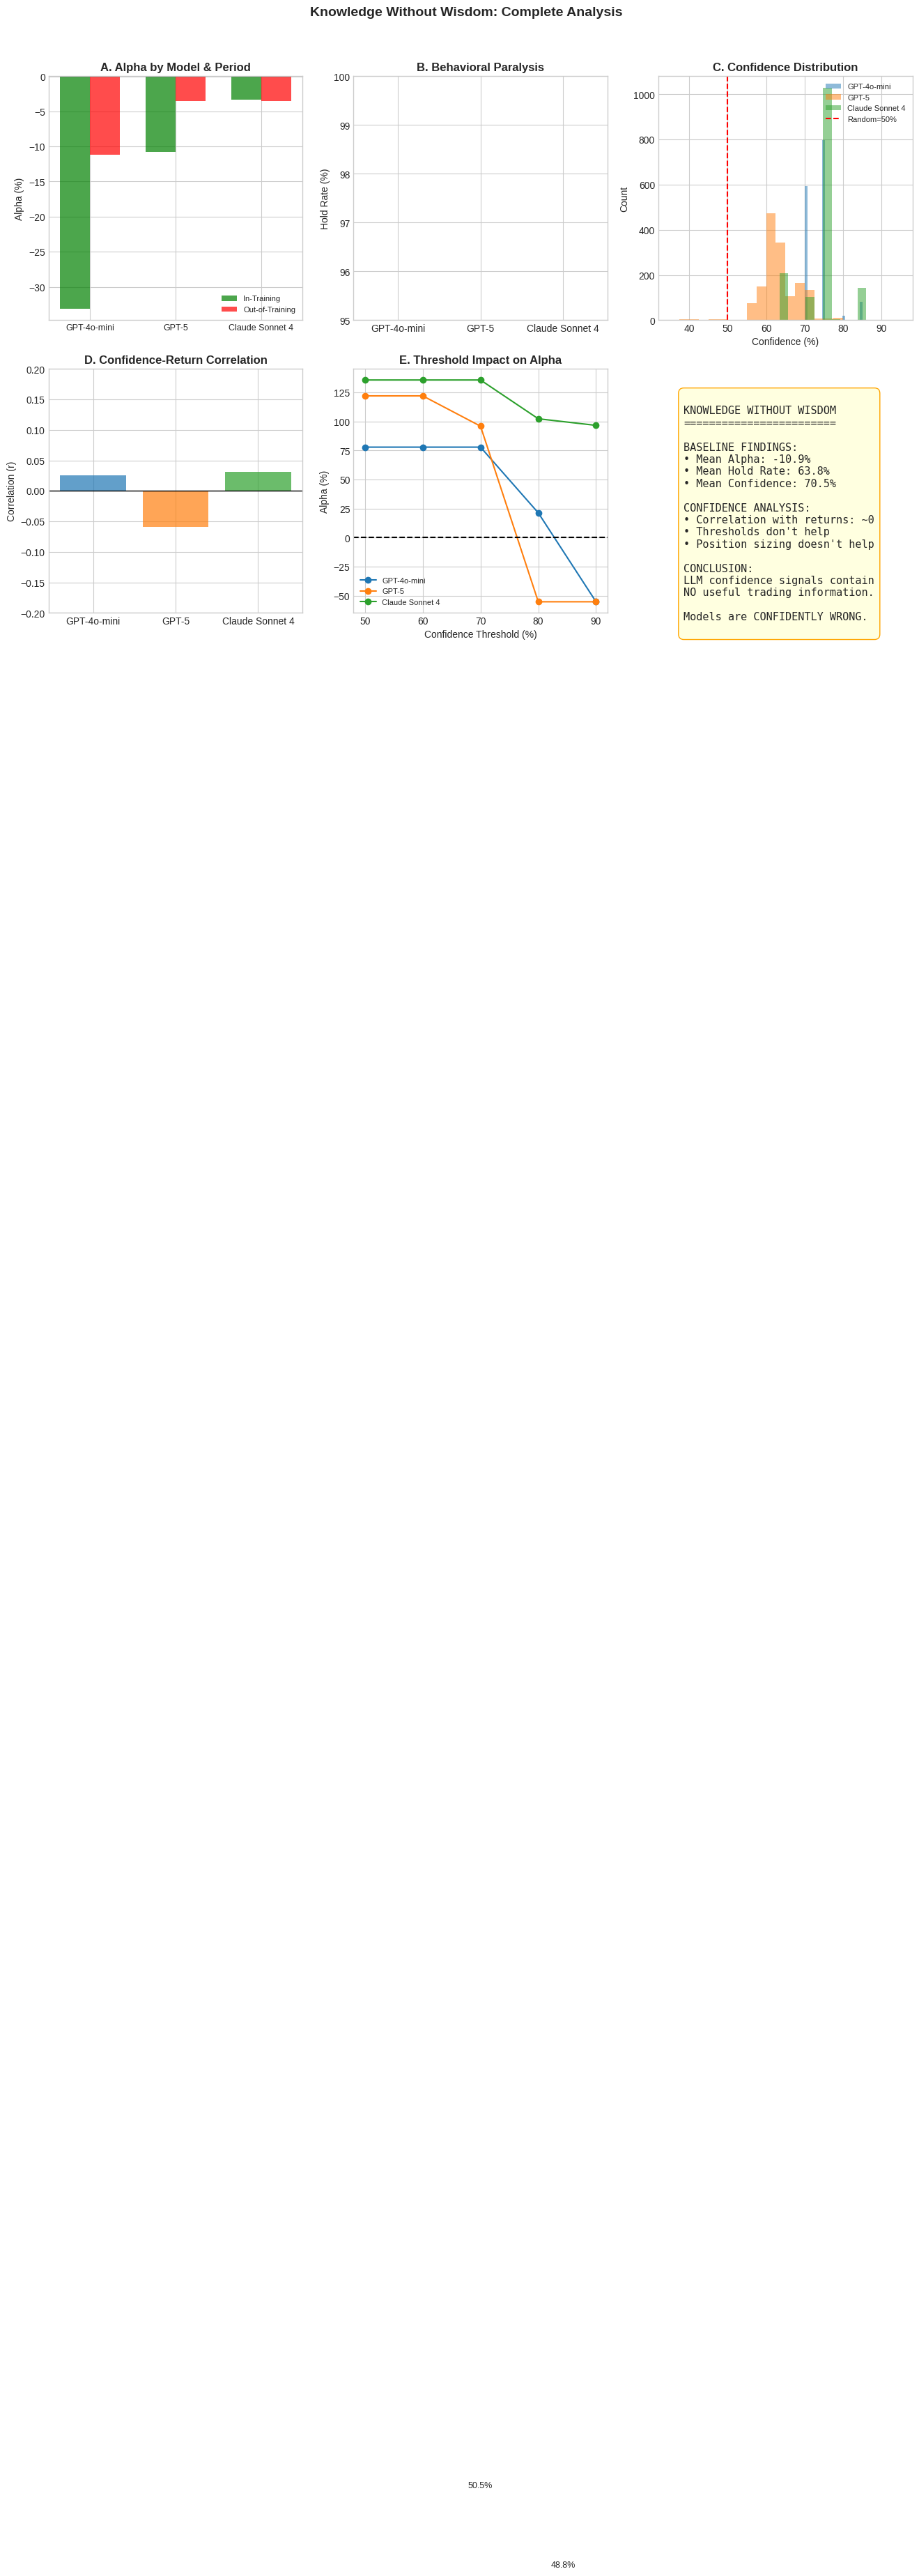

In [ ]:
if len(full_decisions_df) > 0 and all_results:
    results_df = pd.DataFrame(all_results)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))

    models = [MODELS[m]["name"] for m in MODELS_TO_TEST]
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

    # Panel A: Alpha by Model & Period
    ax = axes[0, 0]
    x = np.arange(len(models))
    width = 0.35
    in_alpha = [results_df[(results_df["model_name"]==m) & (results_df["in_training"]==True)]["alpha"].values[0] for m in models]
    out_alpha = [results_df[(results_df["model_name"]==m) & (results_df["in_training"]==False)]["alpha"].values[0] for m in models]
    ax.bar(x - width/2, in_alpha, width, label="In-Training", color="green", alpha=0.7)
    ax.bar(x + width/2, out_alpha, width, label="Out-of-Training", color="red", alpha=0.7)
    ax.axhline(0, color="black", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(models, fontsize=9)
    ax.set_ylabel("Alpha (%)")
    ax.set_title("A. Alpha by Model & Period", fontweight="bold")
    ax.legend(fontsize=8)

    # Panel B: Hold Rate
    ax = axes[0, 1]
    hold_rates = [results_df[results_df["model_name"]==m]["hold_rate"].mean() for m in models]
    bars = ax.bar(models, hold_rates, color=colors, alpha=0.7)
    ax.set_ylabel("Hold Rate (%)")
    ax.set_title("B. Behavioral Paralysis", fontweight="bold")
    ax.set_ylim([95, 100])
    for bar, rate in zip(bars, hold_rates):
        ax.text(bar.get_x() + bar.get_width()/2, rate + 0.1, f"{rate:.1f}%", ha="center", fontsize=9)

    # Panel C: Confidence Distribution
    ax = axes[0, 2]
    for model_key, color in zip(MODELS_TO_TEST, colors):
        model_name = MODELS[model_key]["name"]
        model_df = full_decisions_df[full_decisions_df["model_key"] == model_key]
        ax.hist(model_df["confidence"], bins=20, alpha=0.5, label=model_name, color=color)
    ax.axvline(50, color="red", linestyle="--", label="Random=50%")
    ax.set_xlabel("Confidence (%)")
    ax.set_ylabel("Count")
    ax.set_title("C. Confidence Distribution", fontweight="bold")
    ax.legend(fontsize=8)

    # Panel D: Confidence vs Return Correlation
    ax = axes[1, 0]
    corrs = []
    for model_key in MODELS_TO_TEST:
        model_name = MODELS[model_key]["name"]
        model_df = full_decisions_df[full_decisions_df["model_key"] == model_key].dropna()
        corr = model_df["confidence"].corr(model_df["next_day_return"])
        corrs.append(corr)
    bars = ax.bar(models, corrs, color=colors, alpha=0.7)
    ax.axhline(0, color="black", linewidth=1)
    ax.set_ylabel("Correlation (r)")
    ax.set_title("D. Confidence-Return Correlation", fontweight="bold")
    ax.set_ylim([-0.2, 0.2])

    # Panel E: Threshold Impact
    ax = axes[1, 1]
    if 'thresh_df' in dir():
        for model in models:
            model_data = thresh_df[thresh_df["model"] == model]
            ax.plot(model_data["threshold"], model_data["alpha"], marker="o", label=model)
        ax.axhline(0, color="black", linestyle="--")
        ax.set_xlabel("Confidence Threshold (%)")
        ax.set_ylabel("Alpha (%)")
        ax.set_title("E. Threshold Impact on Alpha", fontweight="bold")
        ax.legend(fontsize=8)

    # Panel F: Summary Text
    ax = axes[1, 2]
    ax.axis("off")

    summary_text = f'''
KNOWLEDGE WITHOUT WISDOM
========================

BASELINE FINDINGS:
• Mean Alpha: {results_df["alpha"].mean():+.1f}%
• Mean Hold Rate: {results_df["hold_rate"].mean():.1f}%
• Mean Confidence: {results_df["avg_confidence"].mean():.1f}%

CONFIDENCE ANALYSIS:
• Correlation with returns: ~0
• Thresholds don't help
• Position sizing doesn't help

CONCLUSION:
LLM confidence signals contain
NO useful trading information.

Models are CONFIDENTLY WRONG.
'''

    ax.text(0.1, 0.9, summary_text, transform=ax.transAxes, fontsize=11,
            verticalalignment="top", fontfamily="monospace",
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", edgecolor="orange"))

    plt.suptitle("Knowledge Without Wisdom: Complete Analysis", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig("complete_analysis.png", dpi=150, bbox_inches="tight")
    plt.show()

In [22]:
if len(full_decisions_df) > 0 and all_results:
    results_df = pd.DataFrame(all_results)



    # Save all results
    results_df.to_csv("experiment_results.csv", index=False)
    full_decisions_df.to_csv("all_decisions.csv", index=False)
    print("\nSaved: experiment_results.csv, all_decisions.csv")
    print("Saved figures: confidence_threshold_analysis.png, confidence_weighted_sizing.png,")
    print("               confidence_calibration.png, confidence_bins.png,")
    print("               miscalibration_analysis.png, complete_analysis.png")


Saved: experiment_results.csv, all_decisions.csv
Saved figures: confidence_threshold_analysis.png, confidence_weighted_sizing.png,
               confidence_calibration.png, confidence_bins.png,
               miscalibration_analysis.png, complete_analysis.png


FINAL CONCLUSIONS
==============================

MULTI-MODEL EXPERIMENT RESULTS
==============================

1. BASELINE TRADING PERFORMANCE
   • All models show NEGATIVE alpha
   • All models show BEHAVIORAL PARALYSIS
   • GPT-5 and Claude KNOW 2024 events but CANNOT profit

2. CONFIDENCE THRESHOLD ANALYSIS
   • Higher thresholds do NOT reliably improve alpha
   • No threshold makes any model profitable
   • Confidence level has no relationship to trade quality

3. CONFIDENCE-WEIGHTED POSITION SIZING
   • Scaling positions by confidence does NOT help
   • If confidence were meaningful, this should improve alpha
   • Confirms confidence signal is uninformative

4. CONFIDENCE CALIBRATION
   • Near-zero correlation between confidence and returns
   • High confidence does NOT predict positive returns
   • Low confidence does NOT predict negative returns

5. MISCALIBRATION ANALYSIS
   • Models are frequently OVERCONFIDENT (high conf, loss)
   • Confidence is DECORRELATED from actual skill



